# 1. Imports

In [1]:
import os
os.environ["HF_HUB_DISABLE_TOKEN_WARNING"] = "1"

from datasets.utils.logging import disable_progress_bar
disable_progress_bar()

import warnings
warnings.simplefilter("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
import pandas as pd

print("Import completed.")

Import completed.


# 2. Load Data and Preprocess Text

In [11]:
# Set the path to the dataset
file_path = "../datasets/WELFake_Dataset.csv"

df = pd.read_csv(file_path)
df = df.dropna(subset=["title", "text", "label"])
df["title"] = df["title"].astype(str)
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the texts in the dataframe
tokenized = tokenizer(
    list(df["title"]),
    truncation=True,
    padding="max_length",
    max_length=256,
    return_tensors="pt"
)

# Extract tensors
input_ids = tokenized["input_ids"]
labels = torch.tensor(df["label"].values, dtype=torch.long)

# Combine inputs and labels
data = list(zip(input_ids, labels))

# 3. Prepare Datasets and Dataloaders

In [12]:
# Train-test split
split_idx = int(0.8 * len(data))
train_data = data[:split_idx]
test_data = data[split_idx:]

# Define custom dataset class
class FakeNewsDataset(Dataset):
    def __init__(self, data):
        """
        Initializes the dataset with the provided data.
        """
        self.data = data

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the sample at the specified index.
        """
        return self.data[idx]

# Create dataset objects for training and testing
dataset = FakeNewsDataset(data)
train_dataset = FakeNewsDataset(train_data)  # Initialize training dataset
test_dataset = FakeNewsDataset(test_data)  # Initialize testing dataset

# Define batch size for training and testing
BATCH_SIZE = 32  # Set batch size

# Create DataLoaders for efficient data loading during training and evaluation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  # DataLoader for training
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)  # DataLoader for testing

print("Data preparation completed.")

Data preparation completed.


# 4. Define the TextCNN Model

In [ ]:
# Define model hyperparameters
VOCAB_SIZE = tokenizer.vocab_size  # Get vocabulary size from tokenizer
EMBEDDING_DIM = 128  # Dimension of word embeddings
NUM_CLASSES = 2  # Number of output classes (real/fake news)
FILTER_SIZES = [3, 5, 7]  # Different filter sizes for convolution layers
NUM_FILTERS = 12  # Number of filters per convolutional layer
NUM_EPOCHS = 12  # Number of training epochs

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, filter_sizes, num_filters):
        """
        Initializes the TextCNN model with embedding, convolutional, and fully connected layers.
        It does not process input data but sets up the model structure.
        """
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding layer
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes  # Apply different filter sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)  # Fully connected layer
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization

    def forward(self, x):
        """
        Define how the input data flows through the network.
        It applies the layers defined in __init__() to the input and computes the output.
        This is where the actual computation (like embedding lookup, convolution, activation functions,
        and classification) happens when the model is used.
        """
        x = self.embedding(x).unsqueeze(1)  # Convert input into embeddings and add a channel dimension
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]  # Apply convolution layers
        x = [torch.max(pool, dim=2)[0] for pool in x]  # Apply max pooling
        x = torch.cat(x, dim=1)  # Concatenate feature maps
        x = self.dropout(x)  # Apply dropout
        return self.fc(x)  # Output layer

# Initialize the TextCNN model with predefined parameters
model = TextCNN(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES, FILTER_SIZES, NUM_FILTERS)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check device availability
model.to(device)  # Move model to selected device

TextCNN(
  (embedding): Embedding(30522, 128)
  (convs): ModuleList(
    (0): Conv2d(1, 12, kernel_size=(3, 128), stride=(1, 1))
    (1): Conv2d(1, 12, kernel_size=(5, 128), stride=(1, 1))
    (2): Conv2d(1, 12, kernel_size=(7, 128), stride=(1, 1))
  )
  (fc): Linear(in_features=36, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

# 5. Train and Evaluate The Model

In [18]:
# Define loss function and optimizer for training
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with specified learning rate

def train_model():
    """
    Trains the model for a specified number of epochs.
    """
    model.train()  # Set model to training mode
    for epoch in range(NUM_EPOCHS):  # Loop through epochs
        total_loss = 0  # Initialize total loss
        for batch in train_loader:  # Iterate over training batches
            inputs, labels = batch  # Unpack input features and labels
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the correct device
            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights
            total_loss += loss.item()  # Accumulate loss
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")  # Print average loss per epoch

def evaluate_model():
    """
    Evaluates the model on the test dataset.
    """
    model.eval()  # Set model to evaluation mode
    correct = 0  # Initialize correct predictions count
    total = 0  # Initialize total sample count
    with torch.no_grad():  # Disable gradient computation during evaluation
        for batch in test_loader:  # Iterate over test batches
            inputs, labels = batch  # Unpack inputs and labels
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the correct device
            outputs = model(inputs)  # Forward pass
            predictions = torch.argmax(outputs, dim=1)  # Get predicted class labels
            correct += (predictions == labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Count total samples
    print(f"Test Accuracy: {correct / total:.4f}")  # Print test accuracy

# Train and evaluate the model
train_model()
evaluate_model()

Epoch 1/20, Loss: 0.3313
Epoch 2/20, Loss: 0.2208
Epoch 3/20, Loss: 0.1736
Epoch 4/20, Loss: 0.1420
Epoch 5/20, Loss: 0.1187
Epoch 6/20, Loss: 0.1001
Epoch 7/20, Loss: 0.0839
Epoch 8/20, Loss: 0.0742
Epoch 9/20, Loss: 0.0632
Epoch 10/20, Loss: 0.0551
Epoch 11/20, Loss: 0.0515
Epoch 12/20, Loss: 0.0460
Epoch 13/20, Loss: 0.0420
Epoch 14/20, Loss: 0.0405
Epoch 15/20, Loss: 0.0352
Epoch 16/20, Loss: 0.0351
Epoch 17/20, Loss: 0.0321
Epoch 18/20, Loss: 0.0291
Epoch 19/20, Loss: 0.0271
Epoch 20/20, Loss: 0.0263
Test Accuracy: 0.9267


# 6. Compute and Display Metrics

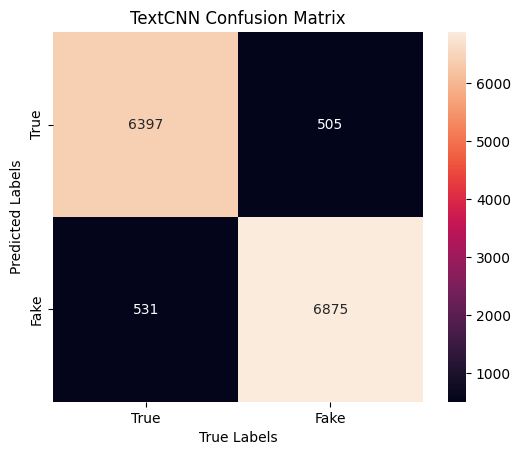

Accuracy: 92.76%
              precision    recall  f1-score   support

        True       0.93      0.92      0.93      6928
        Fake       0.93      0.93      0.93      7380

    accuracy                           0.93     14308
   macro avg       0.93      0.93      0.93     14308
weighted avg       0.93      0.93      0.93     14308



In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Generate predictions using the trained TextCNN model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix heatmap
sns.heatmap(matrix.T,
            square=True,
            annot=True,
            fmt="d",
            xticklabels=["True", "Fake"],
            yticklabels=["True", "Fake"])

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("TextCNN Confusion Matrix")
plt.show()

# Print accuracy and classification report
print("Accuracy: {:.2f}%".format(accuracy_score(all_labels, all_preds) * 100))
print(classification_report(all_labels, all_preds, target_names=["True", "Fake"]))